In [84]:
import numpy as np
import sounddevice as sd
import soundfile as sf
from numpy import ndarray, convolve
from numpy.fft import fft, ifft, rfft, hfft
from scipy.signal import butter, firwin, firwin2, unit_impulse, sosfilt, kaiserord
from shared.record_signal import convert_audio_to_numpy_array, play_sound
import matplotlib.pyplot as plt

import IPython.display as ipd

In [2]:
recording_count = 10
fs = 44100

In [3]:
hd600_audios = []

for i in range(recording_count):
    audio, fs = convert_audio_to_numpy_array(f"../HPIRs_Erbes_44100Hz/Measurements/HD600/pass0{i}.wav")
    hd600_audios.append(audio)

In [4]:
n_input = hd600_audios[0].shape[0]
print('Number of Input steps:\t', n_input)

Number of Input steps:	 17640


In [5]:
hd600_fft = []

for audio in hd600_audios:
    y_l = audio[:, 0]
    y_r = audio[:, 1]
    Y_L = fft(y_l)
    Y_R = fft(y_r)
    Y_fft = np.append([Y_L], [Y_R], axis = 0)
    Y_fft = Y_fft.transpose()
    hd600_fft.append(Y_fft)

In [6]:
n_output = hd600_fft[0].shape[0]
print('Number of output points:\t\t', n_output)
n_output_one_sided = int(n_output / 2 + 1)
print("Number of output points (one-sided):\t", n_output_one_sided)

Number of output points:		 17640
Number of output points (one-sided):	 8821


In [7]:
hd600_fft_mean = []
Y_L_fft_sum = np.empty([n_output])
Y_R_fft_sum = np.empty([n_output])

for Y in hd600_fft:
    Y_L_fft_sum = Y_L_fft_sum + Y[:, 0]
    Y_R_fft_sum = Y_R_fft_sum + Y[:, 1]

Y_L_complex_mean = Y_L_fft_sum / recording_count
Y_R_complex_mean = Y_R_fft_sum / recording_count

Y_complex_mean = np.append([Y_L_complex_mean], [Y_R_complex_mean], axis = 0)

In [8]:
def viz_spectrum(recording, n, ax1_title, ax2_title, fs=44100):
    f_vec = np.linspace(0, fs/2, n)
    left_channel = recording[0, :][: n]
    right_channel = recording[1, :][: n]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 2), sharex=True)

    ax1.set_title(ax1_title)
    ax2.set_title(ax2_title)

    ax1.set_xlabel("Frequency [Hz]")
    ax2.set_xlabel("Frequency [Hz]")

    ax1.semilogx(f_vec, 20*np.log10(np.abs(left_channel)))
    ax2.semilogx(f_vec, 20*np.log10(np.abs(right_channel)))

    ax1.set_xlim([20, fs/2])
    ax1.set_ylim(-60, 30)
    ax2.set_xlim([20, fs/2])
    ax2.set_ylim(-60, 30)

    fig.show()

/var/folders/q_/_sb8ml5x6px7zxlxs9cnf9jc0000gn/T/ipykernel_52070/563957011.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


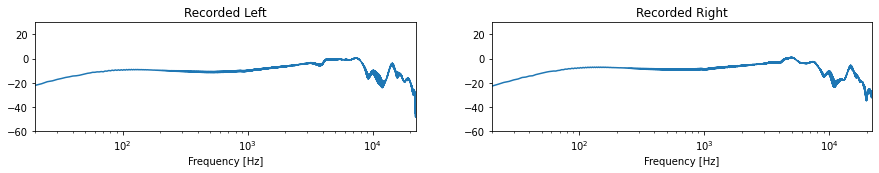

In [9]:
viz_spectrum(Y_complex_mean, n_output_one_sided, 'Recorded Left', 'Recorded Right')

### Design Bandpass Filter

<module 'matplotlib.pyplot' from '/Users/alpargur/Library/Mobile Documents/com~apple~CloudDocs/Uni/Semester-2/VAE/Project/vae-22-project/venv/lib/python3.8/site-packages/matplotlib/pyplot.py'>

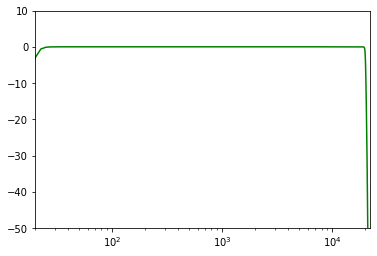

In [44]:
## make fir filter by pushing a dirac through a butterworth SOS (multiple times)

# filter paramters
high_cut = 20000 
low_order = 8
low_cut = 20
high_order = 8

low_pass_filter = high_pass_filter = unit_impulse(n_output)

# lowpass
sos_low_pass = butter(low_order, high_cut, 'lowpass', fs=fs, output='sos')
low_pass_filter = sosfilt(sos_low_pass, low_pass_filter)
low_pass_filter = fft(low_pass_filter)

# highpass
sos_hp = butter(high_order, low_cut, 'highpass', fs=fs, output='sos')
high_pass_filter = sosfilt(sos_hp, high_pass_filter)
high_pass_filter = fft(high_pass_filter)

bandlimit_filter = high_pass_filter * low_pass_filter

#plot
f_vec = np.linspace(0, fs/2, n_output_one_sided)
plt.semilogx(f_vec, 20*np.log10(np.abs(bandlimit_filter[: n_output_one_sided])), color='green')
plt.xlim([20, fs/2])
plt.ylim([-50, 10])
plt


Design Bandpass Filter with Kaiser Window

In [236]:
nyq_rate = fs / 2.0
lowcut_freq = 20.0 / nyq_rate
highcut_freq =20000.0 / nyq_rate
# The desired width of the transition from pass to stop,
# relative to the Nyquist rate.  We'll design the filter
# with a 5 Hz transition width.
width = 5.0/nyq_rate
# The desired attenuation in the stop band, in dB.
ripple_db = 60.0
# Compute the order and Kaiser parameter for the FIR filter.
N, beta = kaiserord(ripple_db, width)
# The cutoff frequency of the filter.
cutoff_hz = 20.0

beta_kaiser = .1102*(ripple_db-8.7);


In [265]:
taps = firwin(n_output+1, [lowcut_freq, highcut_freq], window=('kaiser', beta_kaiser), pass_zero='bandpass')

TAPS = fft(taps, n_output)

In [266]:
TAPS[:]

array([0.00039975+0.00000000e+00j, 0.00039696-6.99013940e-19j,
       0.00038481+4.98690648e-19j, ..., 0.00034741-3.86115826e-18j,
       0.00038481-1.31878316e-17j, 0.00039696+5.85900646e-17j])

Apply Bandpass Filter to L|R channels

In [268]:
Y_L_bandpassed = bandlimit_filter * Y_complex_mean[0]
Y_R_bandpassed = bandlimit_filter * Y_complex_mean[1]
Y_bandpassed = np.append([Y_L_bandpassed], [Y_R_bandpassed], axis = 0)

In [372]:
Y_L_bandpassed_kaiser = TAPS * Y_complex_mean[0]
Y_R_bandpassed_kaiser = TAPS * Y_complex_mean[1]
Y_bandpassed_kaiser = np.append([Y_L_bandpassed_kaiser], [Y_R_bandpassed_kaiser], axis = 0)

Visualize Bandpassed Recording

/var/folders/q_/_sb8ml5x6px7zxlxs9cnf9jc0000gn/T/ipykernel_52070/563957011.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


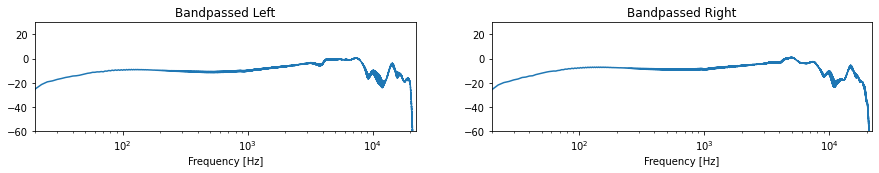

In [269]:
viz_spectrum(Y_bandpassed, n_output_one_sided, 'Bandpassed Left', 'Bandpassed Right')

/var/folders/q_/_sb8ml5x6px7zxlxs9cnf9jc0000gn/T/ipykernel_52070/563957011.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


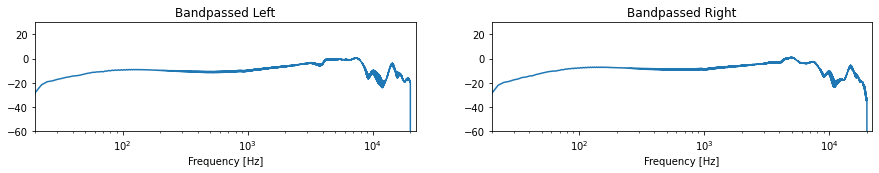

In [373]:
viz_spectrum(Y_bandpassed_kaiser, n_output_one_sided, 'Bandpassed Left', 'Bandpassed Right')

### Design Regularisation Filter

In [270]:
taps = 51
freqs = [0, 0.2, 0.6, 1]
gain = np.array([-20, -20, 0, 0]).astype(float)
linear_gain = 10**(gain/20)
linear_gain[-1] = 0

In [271]:
b = firwin2(taps, freqs, linear_gain, window=('kaiser', 8))

In [272]:
B = fft(b, n_output)

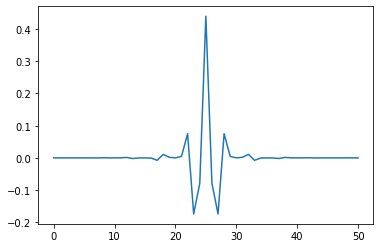

In [273]:
plt.plot(b)

### Calculate Inverse Filter in Frequency Domain

$hc = [H^{T}H + \beta B^{T}B] * H^{T}d$
- $hc$ -> convolution matrice of measured transfer function
- $H$ -> convolution matrice of measured regularisation filter
- $B$ -> signal vector 
- $d$ -> signal vector (latter denoting the delayed IR of target bandpass filter)
- $\beta$ -> weighting regularisation filter

**Important Note**

$\beta$ has the value of 0.1.

In [ ]:
beta = 0.4

In [368]:
# normal bandpass filter
Hc_L = bandlimit_filter.transpose() * np.conj(Y_complex_mean[0]).transpose() / \
    (Y_complex_mean[0].transpose() * np.conj(Y_complex_mean[0]) + beta * B.transpose() * np.conj(B.transpose()))
Hc_R = bandlimit_filter.transpose() * np.conj(Y_complex_mean[1]).transpose() / \
    (Y_complex_mean[1].transpose() * np.conj(Y_complex_mean[1]) + beta * B.transpose() * np.conj(B.transpose()))

Y_inversed = np.append([Hc_L], [Hc_R], axis = 0)

In [369]:
# bandpass filter with kaiser windowing
Hc_L_kaiser = TAPS.transpose() * np.conj(Y_complex_mean[0]).transpose() / \
    (Y_complex_mean[0].transpose() * np.conj(Y_complex_mean[0]) + beta * B.transpose() * np.conj(B.transpose()))
Hc_R_kaiser = TAPS.transpose() * np.conj(Y_complex_mean[1]).transpose() / \
    (Y_complex_mean[1].transpose() * np.conj(Y_complex_mean[1]) + beta * B.transpose() * np.conj(B.transpose()))

Y_inversed_kaiser = np.append([Hc_L_kaiser], [Hc_R_kaiser], axis = 0)

Visualize Signal Processed with Compensation Filter

/var/folders/q_/_sb8ml5x6px7zxlxs9cnf9jc0000gn/T/ipykernel_52070/563957011.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


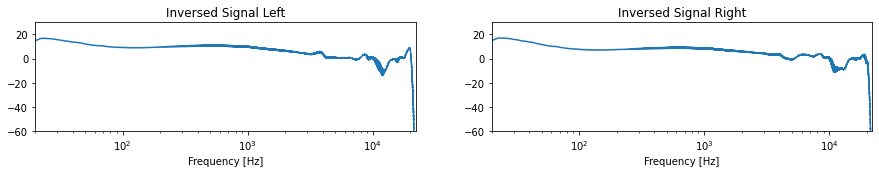

In [370]:
viz_spectrum(Y_inversed, n_output_one_sided, 'Inversed Signal Left', 'Inversed Signal Right')

/var/folders/q_/_sb8ml5x6px7zxlxs9cnf9jc0000gn/T/ipykernel_52070/563957011.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


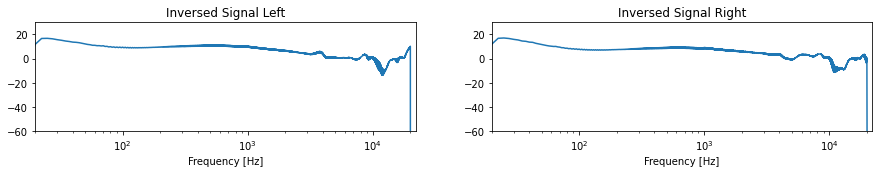

In [371]:
viz_spectrum(Y_inversed_kaiser, n_output_one_sided, 'Inversed Signal Left', 'Inversed Signal Right')

Transfer Back to Time Domain

In [304]:
hc_l = ifft(Hc_L)
hc_r = ifft(Hc_R)
hc_compensated = np.append([hc_l], [hc_r], axis=0)

In [374]:
def viz_sound(recording, n, title, ax1_title, ax2_title, fs=44100):
    t_vec = np.arange(0, n) / fs
    left_channel = recording[0, :]
    right_channel = recording[1, :]

    fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(15, 6), sharex='row', sharey='row')
    

    ax1.set_title(ax1_title)
    ax1.set_xlabel('Seconds')
    ax1.set_ylabel("Amplitude")


    ax2.set_title(ax2_title)
    ax2.set_xlabel('Seconds')
    ax2.set_ylabel("Amplitude")

    ax1.plot(t_vec, left_channel)
    ax2.plot(t_vec, right_channel)

    #ax1.set_xlim([0.0, 0.005])
    #ax1.set_ylim([-1.8, 1.0])
    #ax2.set_xlim([0.0, 0.005])
    #ax2.set_ylim([-1.8, 1.0])

    fig.suptitle(title, fontsize=16)

    fig.show()

/Users/alpargur/Library/Mobile Documents/com~apple~CloudDocs/Uni/Semester-2/VAE/Project/vae-22-project/venv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/var/folders/q_/_sb8ml5x6px7zxlxs9cnf9jc0000gn/T/ipykernel_52070/2868790366.py:28: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


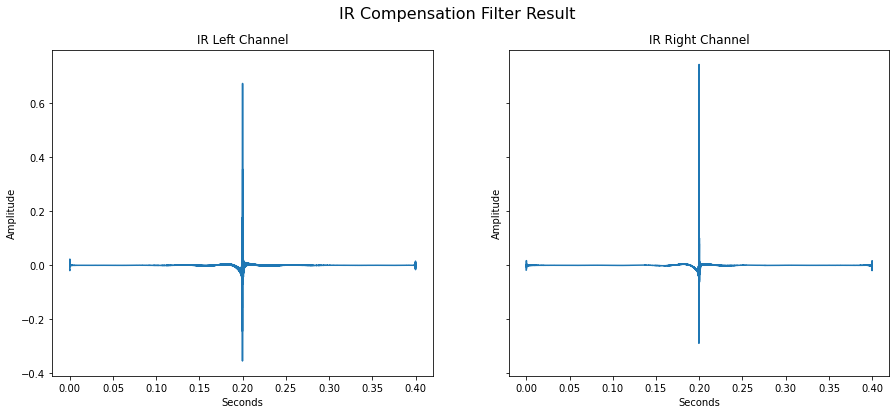

In [375]:
viz_sound(hc_compensated, n_output, 'IR Compensation Filter Result', 'IR Left Channel', 'IR Right Channel')

### Shift Signal and Cut Delay

In [334]:
shifted = np.roll(hc_compensated, 9000)

In [318]:
shifted[1, :]

array([2.19327697e-05+2.15209935e-05j, 3.17883782e-05+3.78273777e-07j,
       1.17234607e-05+1.60226636e-05j, ...,
       2.31427364e-05-2.59432861e-05j, 2.98763669e-05+2.65067179e-05j,
       4.20073053e-05-3.18237246e-05j])

In [336]:
shifted_l = shifted[0, :][: 8000]
shifted_r = shifted[1, :][: 8000]

shifted = np.append([shifted_l], [shifted_r], axis = 0)

In [337]:
shifted.shape

(2, 8000)

In [343]:
shifted = shifted.transpose()

/var/folders/q_/_sb8ml5x6px7zxlxs9cnf9jc0000gn/T/ipykernel_52070/2868790366.py:28: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


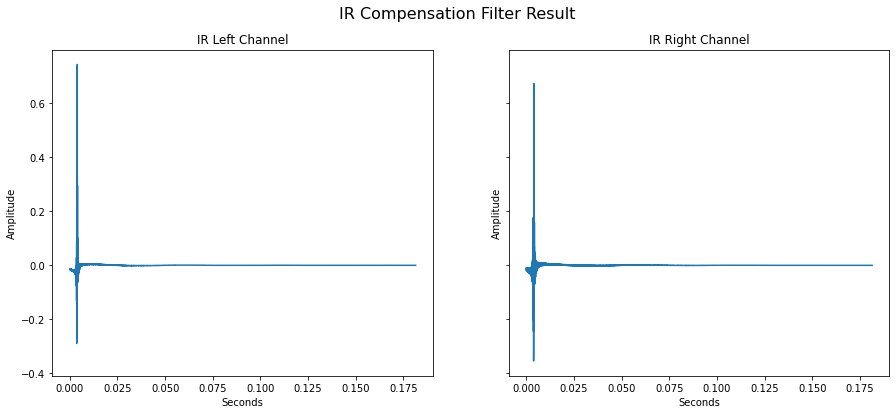

In [344]:
viz_sound(shifted, 8000, 'IR Compensation Filter Result', 'IR Left Channel', 'IR Right Channel')

### Import a drum loop

In [345]:
drum_loop, drum_fs = convert_audio_to_numpy_array(f"../sounds/loops/drum_loop_128_bpm.wav")

In [346]:
drum_loop[0, :]

array([0.00186157, 0.00415039], dtype=float32)

Use Compensation Filter

In [347]:
drum_loop_comp_L  = convolve(drum_loop[:, 0], shifted[0, :])
drum_loop_comp_R  = convolve(drum_loop[:, 1], shifted[1, :])

drum_loop_comp = np.append([drum_loop_comp_L], [drum_loop_comp_R], axis = 0)

In [348]:
drum_loop_comp = drum_loop_comp.transpose()
drum_loop_comp = drum_loop_comp.astype('float32')

/var/folders/q_/_sb8ml5x6px7zxlxs9cnf9jc0000gn/T/ipykernel_52070/336898539.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  drum_loop_comp = drum_loop_comp.astype('float32')


Use Erbes Filter

In [349]:
erbes_comp, fs = convert_audio_to_numpy_array(f"../HPIRs_Erbes_44100Hz/compensation_filters/hpComp_HD600_1Filter.wav")

In [350]:
erbes_comp[0, :]

array([6.604195e-05, 6.604195e-05], dtype=float32)

In [351]:
erbes_drum_loop_comp_L = convolve(drum_loop[:, 0], erbes_comp[:, 0])
erbes_drum_loop_comp_R = convolve(drum_loop[:, 1], erbes_comp[:, 1])

erbes_drum_loop_comp = np.append([erbes_drum_loop_comp_L], [erbes_drum_loop_comp_R], axis = 0)

In [352]:
erbes_drum_loop_comp = erbes_drum_loop_comp.transpose()

In [300]:
# original audio
play_sound(drum_loop, drum_fs)

In [360]:
# audio with compensation filter
play_sound(drum_loop_comp/2, drum_fs)

In [361]:
# audio with erbes filter
play_sound(erbes_drum_loop_comp, fs)